In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import copy
import tqdm
import pickle
# import files from above directory
plt.style.use('dark_background')
import os
import sys
import importlib  

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    # make sure it is added on top to load first in 
    # case there is name conflict with the py files
    sys.path.insert(0,parent_dir)
try:
    importlib.reload(models)
    importlib.reload(bt)
except NameError:
    import models
    import bt

In [2]:
# generate data
n=2000
x=np.random.normal(0,0.01,n)
a=0
b=0.1
y=a+b*x+np.random.normal(0,0.01,n)
dates=pd.date_range('2000-01-01',periods=n,freq='B')
data=pd.DataFrame(np.hstack((y[:,None],x[:,None])),columns=['y1','x1'],index=dates)
print(data)

                  y1        x1
2000-01-03 -0.000945 -0.020720
2000-01-04 -0.000127 -0.006921
2000-01-05  0.004145 -0.011518
2000-01-06  0.003966 -0.002783
2000-01-07  0.004252 -0.000719
...              ...       ...
2007-08-27 -0.007563  0.002848
2007-08-28 -0.007524 -0.001641
2007-08-29  0.011804  0.016846
2007-08-30  0.002697 -0.004121
2007-08-31  0.004094  0.006702

[2000 rows x 2 columns]


In [18]:
# base data element
from typing import List, Dict


def random_subsequence(ar,burn_f=0.1,min_burn_points=1):
    '''
    Generates a random subsequence of an array
    ar: numpy (n,) array 
    burn_f: float between 0 and 1 with the percentage of data to burn at each side
    min_burn_points: integer with the minimum number of points to burn

    return ar[a:-b] where a and b are random indexes to build a subarray from ar
    '''
    min_burn_points=max(min_burn_points,1)
    a,b=np.random.randint(min_burn_points,max(int(ar.size*burn_f),min_burn_points+1),size=2)
    return ar[a:-b]

class Datum(object):
    
    def __init__(self,data):
        '''
        data: pandas DataFrame of list of DataFrames
        '''
        if isinstance(data,pd.DataFrame):
            data=[data]        
        self.check_cols(data)
        
        self.y=[]
        self.x=[]
        self.ts=[]        
        self.z=[]
        self.idx=[]       
                
        for d in data:
            y,x,z,msidx,ts=self.parse_data(d)
            self.y.append(y)
            if x is not None:
                self.x.append(x)
            self.ts+=ts
        self.y=np.vstack(self.y)
        if len(self.x)!=0:
            self.x=np.vstack(self.x)
        else:
            self.x=None
        self.n=self.y.shape[0]
        self.p=self.y.shape[1]
        self.aux_idx=np.arange(self.n,dtype=int)
                
    def view(self):
        print('** Datum **')
        print(
            pd.DataFrame(
                        np.hstack((self.y,self.x)),
                        columns=self.y_cols+self.x_cols,
                        index=self.ts)
            )
    
    def get_model_train_input(self,burn_f=0.1,min_burn_points=1):
        train_idx=random_subsequence(self.aux_idx,burn_f,min_burn_points)
        model_inputs={'y':self.y[train_idx],'x':self.x[train_idx]}
        return model_inputs

    def get_model_test_input(self):
        return {'y':self.y,'x':self.x}    
    
    def check_cols(self,data):
        '''
        data: list of DataFrames
        '''
        self.cols=data[0].columns.tolist()
        self.y_cols=[e for e in self.cols if e[0]=='y']	
        self.x_cols=[e for e in self.cols if e[0]=='x']            
        assert len(self.y_cols)!=0,"data must have columns like y1,y2,..."        
        for e in data:
            assert e.columns.tolist()==self.cols
            
    def parse_data(self,data):
        '''
        data: pandas DataFrame with columns y1,y2,..,<x1>,<x2>,..,<idx>,<z>
        '''
        y=None
        x=None
        z=None
        idx=None
        ts=None
        # get x

        y=data[self.y_cols].values
        ts=data.index.tolist()
        # get x (features)
        if len(self.x_cols)!=0:
                x=data[self.x_cols].values	
        # get idx (subsequence index)
        if 'idx' in self.cols:
            raise Exception('not implemented!')
            tmp=data['idx'].values  
            # idx need to be an array like 000,1111,2222,33,444
            # but can be something like 111,000,11,00000,1111,22
            # i.e, the indexes of the sequence need to be in order for the
            # cvbt to work. Fix the array in case this is not verified
            # this is a bit of overhead but has to be this way
            idx=np.zeros(tmp.size,dtype=int)
            aux=tmp[1:]-tmp[:-1]
            idx[np.where(aux!=0)[0]+1]=1
            idx=np.cumsum(idx)
        # get z (observed state sequence; for example, weekday)
        if 'z' in self.cols:
            raise Exception('not implemented!')
            z=data['z'].values
        return y,x,z,idx,ts 
    
    def build_train_test(self,k_folds=4,seq_path=False,start_fold=0)->List['TrainTestDatum']:
        '''
        Build train and test sets from data
        outputs:
        list of dict of TrainTestDatum
        # TO DO
        # ADD SUPPORT FOR MULTISEQUENCE AND THE OTHER FEATURES IN CVBT
        '''

        if seq_path:
            start_fold=max(1,start_fold)        
        #print('seq_path: ', seq_path)
        #print('start_fold: ',start_fold)
        
        train_test_datum_lst=[]
        n=self.y.shape[0]
        idx=np.arange(n,dtype=int)
        idx_folds=np.array_split(idx,k_folds)
        idx_folds_idx=np.arange(k_folds,dtype=int)
        for i in range(start_fold,k_folds):
            # only passing x and y for now...
            df_test=pd.DataFrame(
                            np.hstack((self.y[idx_folds[i]],self.x[idx_folds[i]])),
                            columns=self.y_cols+self.x_cols,
                            index=dates[idx_folds[i]]
                            )
            df_train=[]
            # indexes before
            tmp_idx=idx_folds_idx[idx_folds_idx<i]
            if tmp_idx.size!=0:
                tmp_idx_folds=np.hstack([idx_folds[e] for e in tmp_idx])
                df_train.append(
                                pd.DataFrame(
                                    np.hstack((self.y[tmp_idx_folds],self.x[tmp_idx_folds])),
                                    columns=self.y_cols+self.x_cols,
                                    index=dates[tmp_idx_folds]
                                    )
                               )
            # indexes after if path is not sequential
            if not seq_path:
                tmp_idx=idx_folds_idx[idx_folds_idx>i]
                if tmp_idx.size!=0:
                    # print(idx_folds)
                    tmp_idx_folds=np.hstack([idx_folds[e] for e in tmp_idx])
                    df_train.append(
                                    pd.DataFrame(
                                        np.hstack((self.y[tmp_idx_folds],self.x[tmp_idx_folds])),
                                        columns=self.y_cols+self.x_cols,
                                        index=dates[tmp_idx_folds]
                                        )
                                   )
            train_test_datum_lst.append(TrainTestDatum(train=[Datum(e) for e in df_train],test=Datum(df_test)))#{'test':Datum(df_test),'train':[Datum(e) for e in df_train]})
        return train_test_datum_lst

class TrainTestDatum(object):
    def __init__(self,train:List['Datum']=None,test:'Datum'=None):
    # def __init__(self,train:List[Datum]=None,test:Datum=None):    
        self.train=train
        if isinstance(self.train,Datum):
            self.train=[self.train]
        self.test=test
        self.n_train_datum=len(self.train)
        self.n_test=self.test.n
        self.p=self.test.p
        self.ts=self.test.ts
    
    def get_model_train_input(self,burn_f=0.1,min_burn_points=1):
        
        # choose one train Datum at random with probability
        # weighted by the number of observations
        # in this class this method is just a selector of training Datum
        p=np.array([self.train[i].n for i in range(self.n_train_datum)],dtype=float)
        p/=np.sum(p)
        print(p)
        idx_train_datum=np.random.choice(np.arange(self.n_train_datum),p=p)       
        return self.train[idx_train_datum].get_model_train_input(burn_f,min_burn_points)
    
    def get_model_test_input(self):
        return self.test.get_model_test_input()
    
    def view(self):
        print('**** TrainTestDatum ****')
        print('*** Train ***')        
        for i in range(self.n_train_datum):
            self.train[i].view()
        print('*** Test ***')
        self.test.view()
            

In [19]:

# EVALUATE THE MODEL
# def evaluate(parameters,model,y,x,idx=None,z=None):
def evaluate(model,y,x,idx=None,z=None):	
    # note: fees can be calculated after this is done!
    if x is not None:
        assert y.shape[0]==x.shape[0],"x and y must have the same number of observations"
    n=y.shape[0]
    p=y.shape[1]
    if idx is None:
        idx=np.array([[0,n]],dtype=int)
    n_seq=idx.shape[0]
    s=np.zeros(n,dtype=np.float64)
    weights=np.zeros((n,p),dtype=np.float64)
    w_prev=np.zeros(p,dtype=np.float64)
    w=np.zeros(p,dtype=np.float64)
    for l in range(n_seq): 
        for i in range(idx[l][0],idx[l][1]):
            # build inputs for model
            model_inputs={'y':y[idx[l][0]:i]}
            if x is not None:
                model_inputs.update({'x':x[idx[l][0]:i]})
                model_inputs.update({'xq':x[i]})
            if z is not None:
                model_inputs.update({'z':z[i]})
            w=model.get_weight(**model_inputs)
            weights[i]=w
            s[i]=np.dot(y[i],w)
    # compute fees here	
    return s,weights


In [20]:
class CVBTOut(object):
    def __init__(self,s,weights,ts):
        self.s=s
        self.weights=weights        
        self.ts=ts        
        self.s_fees=None
        #self.seq_fees=seq_fees
        #self.pct_fees=pct_fees
        #self.sr_mult=sr_mult
        #self.n_boot=n_boot
        # self.n_paths=n_paths
        self.n_paths=self.s.shape[1]        
        # seq_fees=None,pct_fees=None,sr_mult=1,n_boot=100,n_paths=1
        
    def calculate_fees(self,seq_fees,pct_fees):
        if seq_fees:
            dw=np.abs(self.weights[1:]-self.weights[:-1])
            dw=np.vstack(([np.zeros_like(dw[0])],dw))
            dw=np.sum(dw,axis=1)
        else:
            dw=np.sum(np.abs(self.weights),axis=1)
        s_fees=np.zeros((pct_fees.size,self.s.shape[0],self.s.shape[1]))
        for i in range(pct_fees.size):
            s_fees[i]=self.s-pct_fees[i]*dw
        return s_fees

    def bootstrap_sharpe(self,s,n_boot=1000):
        l=s.size
        idx=np.arange(l,dtype=int)
        idx_=np.random.choice(idx,(l,n_boot),replace=True)
        s_=s[idx_]
        boot_samples=np.mean(s_,axis=0)/np.std(s_,axis=0)
        return boot_samples

    def post_process(self,seq_fees=False,pct_fees=[0],sr_mult=1,n_boot=1000):

        if isinstance(pct_fees,float):
            pct_fees=np.array([pct_fees])
        elif isinstance(pct_fees,int):
            pct_fees=np.array([pct_fees])
        else:
            pct_fees=np.array(pct_fees)   

        s_fees=self.calculate_fees(seq_fees,pct_fees)

        # make plots!
        paths_sr=sr_mult*np.mean(self.s,axis=0)/np.std(self.s,axis=0)
        idx_lowest_sr=np.argmin(paths_sr)

        b_samples=self.bootstrap_sharpe(self.s[:,idx_lowest_sr],n_boot=n_boot)
        b_samples*=sr_mult
        valid=False
        if np.sum(b_samples<0)==0:
            valid=True
        if valid:
            print('-> ACCEPT STRATEGY')
        else:
            print('-> REJECT STRATEGY')
        print()
        print('** Performance summary **')
        print()
        print('Return: ', np.power(sr_mult,2)*np.mean(self.s))
        print('Standard deviation: ', sr_mult*np.std(self.s))
        print('Sharpe: ', sr_mult*np.mean(self.s)/np.std(self.s))
        print()
        for i in range(pct_fees.size):
            print('Return fee=%s: '%pct_fees[i], 
                  np.power(sr_mult,2)*np.mean(s_fees[i]))
            print('Standard deviation fee=%s: '%pct_fees[i], 
                  sr_mult*np.std(s_fees[i]))
            print('Sharpe fee=%s: '%pct_fees[i], 
                  sr_mult*np.mean(s_fees[i])/np.std(s_fees[i]))
            print()
        print('**')

        # bootstrap estimate of sharpe
        if self.n_paths!=1:
            plt.title('Distribution of paths SR [no fees]')
            plt.hist(paths_sr,density=True)
            plt.show()
            for i in range(pct_fees.size):
                tmp=sr_mult*np.mean(s_fees[i],axis=0)/np.std(s_fees[i],axis=0)
                plt.title('Distribution of paths SR [fee=%s]'%pct_fees[i])
                plt.hist(tmp,density=True)
                plt.show()

        c=['r','y','m','b']
        aux=pd.DataFrame(np.cumsum(self.s,axis=0),index=self.ts)
        aux.plot(color='g',title='Equity curves no fees',legend=False)
        plt.grid(True)
        plt.show()

        ax=aux.plot(color='g',title='Equity curves w/ fees',legend=False)
        for i in range(min(pct_fees.size,len(c))):
            aux=pd.DataFrame(np.cumsum(s_fees[i],axis=0),index=self.ts)
            ax=aux.plot(ax=ax,color=c[i],legend=False)
        plt.grid(True)
        plt.show()

        plt.title('(Worst path) SR bootstrap distribution')
        plt.hist(b_samples,density=True)
        plt.grid(True)
        plt.show() 

        plt.title('Strategy returns distribution')
        plt.hist(self.s.ravel(),bins=50,density=True)
        plt.grid(True)
        plt.show()		

        aux=pd.DataFrame(np.sum(self.weights,axis=1),index=self.ts)
        aux.plot(title='Weights sum',legend=False)
        plt.grid(True)
        plt.show()

        aux=pd.DataFrame(np.sum(np.abs(self.weights),axis=1),index=self.ts)
        aux.plot(title='Total Leverage',legend=False)
        plt.grid(True)
        plt.show()

        p=self.weights.shape[1]

        for i in range(p):
            aux=pd.DataFrame(self.weights[:,i,:],index=self.ts)
            aux.plot(title='Weights for asset %s'%(i+1),legend=False)
            plt.grid(True)
            plt.show()
            
            

 20%|████████████████▌                                                                  | 4/20 [00:00<00:00, 34.78it/s]

seq_path:  True
start_fold:  2
**** TrainTestDatum ****
*** Train ***
** Datum **
                  y1        x1
2000-01-03 -0.000945 -0.020720
2000-01-04 -0.000127 -0.006921
2000-01-05  0.004145 -0.011518
2000-01-06  0.003966 -0.002783
2000-01-07  0.004252 -0.000719
...              ...       ...
2003-10-27 -0.015029 -0.021487
2003-10-28 -0.023308 -0.007231
2003-10-29  0.011738 -0.002464
2003-10-30  0.018033  0.007268
2003-10-31 -0.001060 -0.014633

[1000 rows x 2 columns]
*** Test ***
** Datum **
                  y1        x1
2003-11-03 -0.009343  0.011343
2003-11-04  0.011177  0.008613
2003-11-05 -0.012221 -0.014117
2003-11-06  0.006993 -0.008551
2003-11-07 -0.004296 -0.011593
...              ...       ...
2005-09-26 -0.000609  0.015307
2005-09-27 -0.008035 -0.015428
2005-09-28  0.000268  0.017517
2005-09-29 -0.005593  0.005074
2005-09-30 -0.011642 -0.000944

[500 rows x 2 columns]
**** TrainTestDatum ****
*** Train ***
** Datum **
                  y1        x1
2000-01-03 -0.0009

 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:00, 33.98it/s]

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:00<00:00, 34.41it/s]

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.11it/s]


[1.]
[1.]
-> REJECT STRATEGY

** Performance summary **

Return:  0.0004116430604261476
Standard deviation:  0.004503736241176812
Sharpe:  0.0914003481515131

Return fee=0:  0.0004116430604261476
Standard deviation fee=0:  0.004503736241176812
Sharpe fee=0:  0.0914003481515131

**


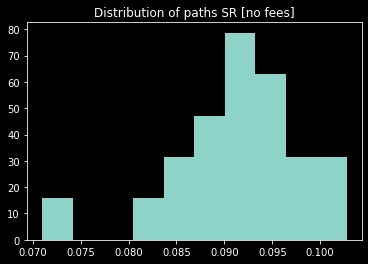

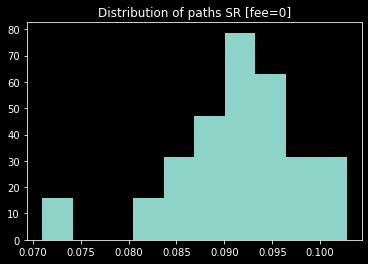

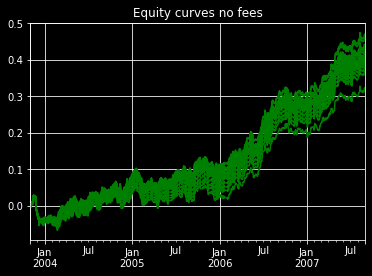

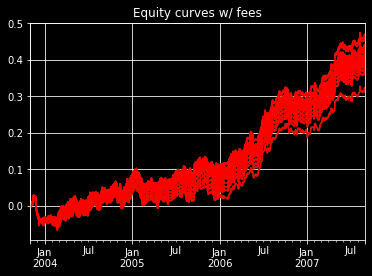

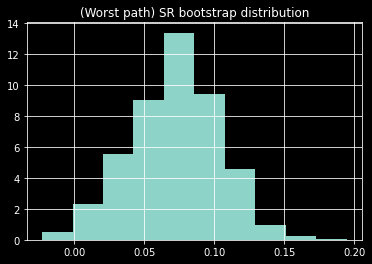

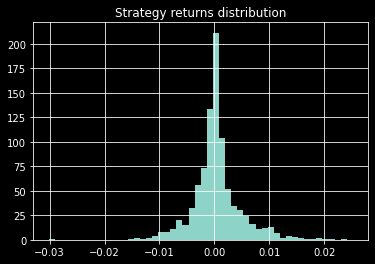

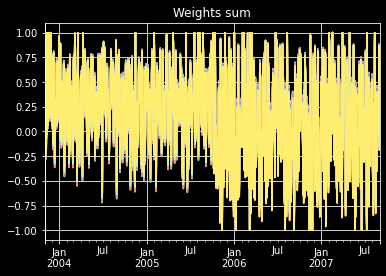

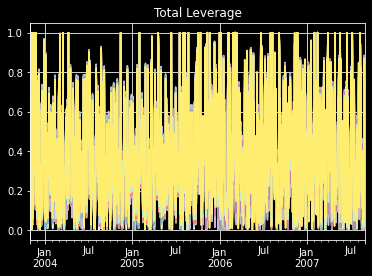

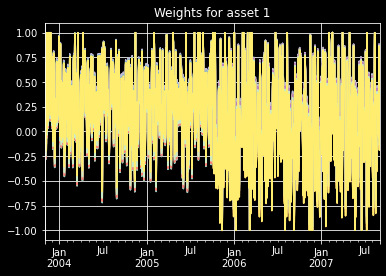

In [25]:
def cvbt(train_test_datum_lst:List['TrainTestDatum'],model,):
    '''
    train_test_datum: list of dict of TrainTestDatum
    model: instance of the model class
    '''
    
    # parameters to receive as inputs
    burn_f=0.1
    min_burn_points=1    
    n_paths=20
    
    # number of train/test sets
    n_train_test=len(train_test_datum_lst)
    # total number of test observations
    # build test idx to store performance and weights
    # store test index (datetimes, etc)
    n_test=0
    test_idx=[]
    ts=[]
    aux_max=0
    for i in range(n_train_test):
        n_test+=train_test_datum_lst[i].n_test
        test_idx.append(np.arange(train_test_datum_lst[i].n_test))
        test_idx[-1]+=aux_max
        aux_max=test_idx[-1][-1]+1
        ts+=train_test_datum_lst[i].ts
    # number of variables
    p=train_test_datum_lst[0].p
    # store performance
    s=np.zeros((n_test,n_paths),dtype=np.float64) 
    # store weights
    weights=np.zeros((n_test,p,n_paths),dtype=np.float64)        
    # run this for all paths
    for m in tqdm.tqdm(range(n_paths)):    
        # CVBT routine
        # select random set of training data
        # evaluate model
        # store results
        for i in range(n_train_test):        
            # create copy of model
            local_model=copy.deepcopy(model)
            # train
            model_train_input=train_test_datum_lst[i].get_model_train_input(burn_f,min_burn_points)
            local_model.estimate(**model_train_input)
            # evaluate     
            s[test_idx[i],m],weights[test_idx[i],:,m]=evaluate(
                                                    local_model,
                                                    **train_test_datum_lst[i].get_model_test_input()
                                                    )
    out=CVBTOut(s,weights,ts)
    return out            
            
    

# convert data to Datum object
datum=Datum(data)
# build train test sets from Datum
train_test_datum_lst=datum.build_train_test(k_folds=4,seq_path=True,start_fold=2)
for e in train_test_datum_lst:
    e.view()
#print(sdfsdf)

model=models.ConditionalGaussian(n_gibbs=None)
out=cvbt(train_test_datum_lst,model)
out.post_process()
